In [1]:
from text2vec0 import text2vec
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style

In [3]:
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.cluster import KMeans

### abstract doc2vec

In [4]:
from importlib import reload
import text2vec0
reload(text2vec0)
from text2vec0 import text2vec

In [5]:
import pickle
from sklearn.model_selection import train_test_split

In [6]:
obesity = pd.read_csv('obesity_text.tsv', sep='\t')  # 원본 데이터

In [7]:
obesity['claim'] = obesity['claim'].str[2:]  # claim 번호 삭제

In [7]:
obesity.shape

(148, 5)

In [8]:
obesity

,patent_id,title,claim,abstract,class
0,3951745,Glycoside-hydrolase enzyme inhibitors,A method for the production of an inhibitor o...,This invention relates to inhibitors for glyco...,1AA
1,3995026,Amylase inhibitor,A pharmaceutical composition comprising an ad...,The invention relates to an amylase inhibitor ...,1AA
2,4013510,Glycoside-hydrolase enzyme inhibitors,A method of inhibiting the reaction of carboh...,This invention relates to inhibitors for glyco...,1AA
3,4042687,Method of treating obesity by the oral adminis...,A method of treating obesity which comprises ...,A method of preventing obesity which comprises...,1AA
4,4115587,Fatty acid amides of norfenfluramine and compo...,A fatty acid amide of norfenfluramine having ...,Novel amides of norfenfluramine having the for...,1AB
5,4211765,Method for controlling obesity,A method of countering a tendency toward obes...,The invention involves a method of weight cont...,1BA
6,4442113,Long-term weight reduction of obese patients u...,The method of reducing appetite to obtain wei...,A method for assisting with appetite and weigh...,1AB
7,4634795,"Long-chain .alpha.,.omega.-di-carboxylic acids...",A compound of the formula wherein X is hydro...,A novel class of compounds has been found to b...,1BB
8,4689344,"Long-chain .alpha.,.omega.-dicarboxylic acids ...","A pharmaceutical composition comprising, as a...",A novel class of compounds has been found to b...,1BB
9,5109006,"Certain pharmaceutically active 6H-imidazo[1,2...",A compound of the formula their enantiomers ...,This invention relates to novel derivatives of...,1AB


In [9]:
# Randomly sample 70% of your dataframe
obesity_train = obesity.sample(frac=0.7)  # train data set

In [10]:
obesity_train['class'].value_counts()

1BD    35
1BB    17
1AB    17
1BA    16
1AA    11
1BC     8
Name: class, dtype: int64

In [11]:
obesity_test = obesity[~obesity.index.isin(obesity_train.index)]  # test data set

In [12]:
obesity_test['class'].value_counts()

1BD    22
1AB    11
1BB     5
1BA     3
1AA     2
1BC     1
Name: class, dtype: int64

### Train data merge (Title, abstract, claim 순으로 concat)

In [13]:
obesity_train_vertical = pd.DataFrame(columns=['index', 'patent_id', 'class', 'text', 'label'])  # 빈 df 생성

In [14]:
# concat df에 title, abstract, claim 순으로 데이터 넣기 (label, index의 range는 데이터 숫자만큼 알아서 조정)
for col in ['title', 'abstract', 'claim']:
    concat_df = pd.DataFrame(columns=['index', 'patent_id', 'class', 'text', 'label'])  # title, abstract, claim이 각각 들어갈 임시 df
    concat_df['patent_id'] = obesity_train['patent_id']
    concat_df['class'] = obesity_train['class']
    concat_df['text'] = obesity_train[col]
    concat_df['label'] = [str(i)+'_'+col for i in range(obesity_train.shape[0])]
    concat_df['index'] = [i for i in range(obesity_train.shape[0])] 

    # 최종 df(obesity_vertical) 랑 concat 이랑 합침
    obesity_train_vertical = obesity_train_vertical.append(concat_df)

In [15]:
obesity_train_vertical.reset_index(inplace=True) # reset_index

In [16]:
obesity_train_vertical.drop(['level_0'], axis=1, inplace=True)

In [17]:
pd.to_pickle(obesity_train_vertical, './obesity_train_vertical.pkl')

### Test data merge(title, abstract, claim 순으로 concat)

In [18]:
obesity_test_vertical = pd.DataFrame(columns=['index', 'patent_id', 'class', 'text', 'label'])  # 빈 df 생성

In [19]:
# concat df에 title, abstract, claim 순으로 데이터 넣기 (label, index의 range는 데이터 숫자만큼 알아서 조정)
for col in ['title', 'abstract', 'claim']:
    concat_df = pd.DataFrame(columns=['index', 'patent_id', 'class', 'text', 'label'])  # title, abstract, claim이 각각 들어갈 임시 df
    concat_df['patent_id'] = obesity_test['patent_id']
    concat_df['class'] = obesity_test['class']
    concat_df['text'] = obesity_test[col]
    concat_df['label'] = [str(i)+'_'+col for i in range(obesity_test.shape[0])]
    concat_df['index'] = [i for i in range(obesity_test.shape[0])] 

    # 최종 df(obesity_vertical) 랑 concat 이랑 합침
    obesity_test_vertical = obesity_test_vertical.append(concat_df)

In [20]:
pd.to_pickle(obesity_test_vertical, './obesity_test_vertical.pkl')

### Embedding

In [27]:
abstract2vec = text2vec(filename='obesity_train_vertical.pkl', class_name='obesity_glove', model='glove', n_dim=100, )

In [28]:
model, X = abstract2vec.train_glove()

In [31]:
X.shape

(312, 100)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [32]:
model.docvecs.save("obesity_glove.model")

AttributeError: 'Glove' object has no attribute 'docvecs'

In [24]:
title = X[:104]
abstract = X[104:208]
claim = X[208:]

In [25]:
train = pickle.load(open('./obesity_train_vertical.pkl', 'rb'))

In [26]:
train_class = train[:104]['class']

In [27]:
col_dict = {'title': title, 'abstract': abstract, 'claim': claim}
for col in col_dict:
    print(col)
    for i in train_class.index:
        col_dict[col][i] = np.append(col_dict[col][i], train_class[i])
    np.save('glove_train_'+col+"_obesity.npy", col_dict[col])
    print('glove_train_'+col+"_obesity.npy Save")

title
train_title_obesity.npy Save
abstract
train_abstract_obesity.npy Save
claim
train_claim_obesity.npy Save


In [28]:
test = pickle.load(open('./obesity_test_vertical.pkl', 'rb'))

In [32]:
test_class = test[104:]['class']

In [33]:
col_dict_test = {'title': title, 'abstract': abstract, 'claim': claim}
for col in col_dict_test:
    print(col)
    for i in test_class.index:
        print(i)
        col_dict_test[col][i] = np.append(col_dict_test[col][i], test_class[i])
    np.save('glove_test_'+col+"_obesity.npy", col_dict_test[col])
    print('glove_test_'+col+"_obesity.npy Save")

title
31
34
36
42
43
50
53
59
66
69
73
77
78
82
91
99
100
101
106


IndexError: list index out of range

In [34]:
def clean_text(filename):
    import re
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    import string
    df = pd.read_pickle(filename)
    abstract = df["text"]
    labels = df.patent_id
        
    re_punc = re.compile("[%s]" % re.escape(string.punctuation))
    text_concat = [re_punc.sub("", text.lower()) for text in abstract]

    stop_words = set(stopwords.words('english'))
    word_tokens = [word_tokenize(text) for text in text_concat]

    word_tokens = [[w for w in row if(w not in stop_words)] for row in word_tokens]
    filtered_sentence = [[w for w in row if(w.strip() != "")] for row in word_tokens]
        
    cleaned_text = [row for row in filtered_sentence]

    return cleaned_text

### 아래는 테스트 임베딩 하는 거

In [35]:
test_word_list = clean_text('./obesity_test_vertical.pkl')

In [36]:
len(test_word_list)

132

In [37]:
test_title = test_word_list[:44]
test_abstract = test_word_list[44:88]
test_claim = test_word_list[88:]

In [38]:
# vectorization 하는 코드
test_col_dict = {'title': test_title, 'abstract': test_abstract, 'claim': test_claim}
for col in test_col_dict:
    print(col)
    infer_list = []
    for i in range(len(test_title)):
        tmp = model.infer_vector(doc_words=test_col_dict[col][i])
        infer_list.append(tmp)
    np.save("glove_test_"+col+"_obesity.npy", infer_list)
    print("glove_test_"+col+"_obesity.npy Save")

title
test_title_obesity.npy Save
abstract
test_abstract_obesity.npy Save
claim
test_claim_obesity.npy Save


In [39]:
# + text2vec0.py 파일에  text_preproce~~ 수정해야 할 부분 (stopword 제대로 안날아감)
        stop_words = set(stopwords.words('english'))
        word_tokens = [word_tokenize(text) for text in text_concat]

        word_tokens = [[w for w in row if(w not in stop_words)] for row in word_tokens]
        filtered_sentence = [[w for w in row if(w.strip() != "")] for row in word_tokens]
####################여기 위에까지가 내가 다시 전처리한 코드! ############################################

IndentationError: unexpected indent (<ipython-input-39-c3fd5812dade>, line 2)

In [40]:
test = pickle.load(open('./obesity_test_vertical.pkl', 'rb'))

In [41]:
test.reset_index(inplace=True)

In [42]:
test_class = test[:44]['class']

In [43]:
test_abstract = np.load('./test_abstract_obesity.npy')
tmp = np.array([]).reshape(-1, 101)
for i in test_class.index:
    a = np.hstack((test_abstract[i], test_class[i]))
    tmp = np.vstack((tmp, a))
np.save("test_abstract_obesity.npy", tmp)

In [44]:
test_title = np.load('./test_title_obesity.npy')
tmp = np.array([]).reshape(-1, 101)
for i in test_class.index:
    a = np.hstack((test_title[i], test_class[i]))
    tmp = np.vstack((tmp, a))
np.save("test_title_obesity.npy", tmp)

In [45]:
test_claim = np.load('./test_claim_obesity.npy')
tmp = np.array([]).reshape(-1, 101)
for i in test_class.index:
    a = np.hstack((test_claim[i], test_class[i]))
    tmp = np.vstack((tmp, a))
np.save("test_claim_obesity.npy", tmp)

In [46]:
def embedding_graph(X, y_predict):
    style.use("ggplot")
    N = 6
    colors = ['r', 'g', 'b', 'y', 'pink', 'gray']
    color_list = [colors[y] for y in y_predict]

    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=3).fit(X)
    X_embedded = tsne.fit_transform(X)

    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=color_list, s=10, cmap='viridis')
    plt.show()

In [47]:
from sklearn.mixture import GaussianMixture

def predict(X):
#     kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
#     y_predict = kmeans.predict(X)
    
    from sklearn.mixture import GaussianMixture

    gmm = GaussianMixture(
            n_components=6, covariance_type='diag').fit(X)

    y_predict = gmm.predict(X)

    return y_predict

def accuracy(y_predict, Y):
    y_true=np.array(Y)
    assert y_predict.size == y_true.size

    D = int(max(y_predict.max(), y_true.max())+1)
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_predict.shape[0]):
#         print(y_predict.shape, y_true.shape)
        w[(y_predict[i]).astype('int64'), y_true[i]] += 1

    ind = linear_assignment(w.max() - w)
    accuracy = sum([w[i, j] for i, j in ind])*1.0/y_predict.size, w
    return accuracy[0]

In [48]:
def get_top_score(X, iteration=20):
    top_score = 0
    for _ in range(iteration):
        y_predict = predict(X)
        score = accuracy(y_predict, Y)
        print(score)
        if top_score < score:
            top_score = score
    return top_score

In [49]:
x = np.concatenate([test_title,test_abstract,test_claim])

In [50]:
predict_y = predict(X)

In [51]:
(np.eye(6)[predict_y]).shape

(312, 6)

In [52]:
Y = train['class'].str.get_dummies()
Y.columns = [0,1,2,3,4,5]
Y = Y.idxmax(axis=1)

In [53]:
get_top_score(X, iteration=20)

0.34294871794871795
0.3301282051282051
0.32371794871794873
0.32051282051282054
0.3173076923076923
0.3333333333333333
0.34294871794871795
0.3141025641025641
0.3108974358974359
0.3269230769230769
0.3301282051282051
0.32371794871794873
0.33653846153846156
0.33974358974358976
0.3173076923076923
0.3333333333333333
0.33974358974358976
0.3301282051282051
0.3525641025641026
0.4166666666666667


0.4166666666666667

In [54]:
predict_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0,
       0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0,
       0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 0, 5, 5,
       0, 1, 5, 1, 5, 1, 5, 1, 1, 5, 0, 1, 5, 5, 5, 0, 0, 5, 5, 0, 5, 1,
       5, 1, 5, 5, 5, 5, 1, 5, 5, 5, 1, 0, 5, 5, 5, 0, 5, 0, 5, 5, 5, 5,
       5, 5, 5, 0, 5, 1, 5, 1, 5, 1, 5, 5, 5, 0, 5, 5, 5, 1, 0, 5, 5, 1,
       5, 5, 5, 5, 0, 5, 0, 5, 1, 5, 5, 5, 5, 5, 1, 5, 1, 5, 1, 0, 1, 5,
       5, 0, 1, 0, 0, 5, 1, 1, 5, 1, 1, 5, 1, 1, 5, 5, 0, 1, 0, 5, 1, 5,
       0, 1, 5, 5, 5, 5, 1, 1, 1, 0, 0, 5, 5, 5, 5, 5, 0, 0, 1, 1, 5, 1,
       1, 1, 5, 1, 1, 1, 5, 1, 1, 5, 5, 0, 1, 5, 1, 1, 5, 1, 1, 0, 5, 0,
       4, 5, 5, 1, 1, 1, 0, 5, 2, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 5, 0, 1,
       0, 1, 1, 1, 5, 5, 0, 2, 5, 1, 5, 5, 5, 0, 3,

In [55]:
predict_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0,
       0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0,
       0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 0, 5, 5,
       0, 1, 5, 1, 5, 1, 5, 1, 1, 5, 0, 1, 5, 5, 5, 0, 0, 5, 5, 0, 5, 1,
       5, 1, 5, 5, 5, 5, 1, 5, 5, 5, 1, 0, 5, 5, 5, 0, 5, 0, 5, 5, 5, 5,
       5, 5, 5, 0, 5, 1, 5, 1, 5, 1, 5, 5, 5, 0, 5, 5, 5, 1, 0, 5, 5, 1,
       5, 5, 5, 5, 0, 5, 0, 5, 1, 5, 5, 5, 5, 5, 1, 5, 1, 5, 1, 0, 1, 5,
       5, 0, 1, 0, 0, 5, 1, 1, 5, 1, 1, 5, 1, 1, 5, 5, 0, 1, 0, 5, 1, 5,
       0, 1, 5, 5, 5, 5, 1, 1, 1, 0, 0, 5, 5, 5, 5, 5, 0, 0, 1, 1, 5, 1,
       1, 1, 5, 1, 1, 1, 5, 1, 1, 5, 5, 0, 1, 5, 1, 1, 5, 1, 1, 0, 5, 0,
       4, 5, 5, 1, 1, 1, 0, 5, 2, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 5, 0, 1,
       0, 1, 1, 1, 5, 5, 0, 2, 5, 1, 5, 5, 5, 0, 3,

In [58]:
accuracy(predict_y, Y)

0.3301282051282051

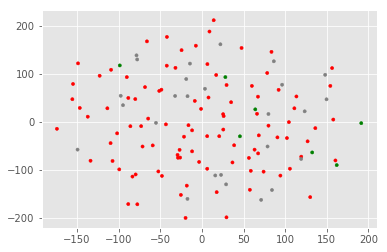

In [59]:
embedding_graph(x, predict_y)

In [1]:

import network2vec

In [2]:
from network2vec import network2vec


In [4]:
net2vec = network2vec(labels=label,
                    model='doc2vec', filename='pickles/obesity_4digit_ipc.pkl',
                    class_name='ipc', is_network=False)

NameError: name 'label' is not defined